# recurrent-amps-plot.ipynb
Count all oncogenes amplified in n >= 3 tumors. Make a cool plot about it. See **Fig. 2b**.

## Requirements
- conda dependencies in `r-amplification.yml`
- `genes.txt` contains gene names to plot

In [1]:
Sys.setenv(LANGUAGE = "en")

library(readxl)
library(ggplot2)
library(tidyverse)
library(janitor)
library(writexl)
library(cowplot)
library(extrafont)
library(svglite)

extrafont::font_import(pattern="Arial",prompt=FALSE)
extrafont::loadfonts()

Warning message:
“package ‘readxl’ was built under R version 4.4.3”
── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Warning message:
“package ‘writexl’ was built under R version 4.4.3”

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Register

In [2]:
import_ecDNA_amplicons <- function(file_path){
    # Get a table of genes amplified on ecDNA in this cohort.
    
    # S.T.2 columns:
    # biosample_id sex patient_id external_sample_id tumor_history age_at_diagnosis cohort extent_of_tumor_resection file_name cancer_type cancer_subclass ecDNA_sequences_detected amplicon_class in_unique_tumor_set in_unique_patient_set
    biosamples <- suppressWarnings(
      read_excel(file_path, sheet = "2. Biosamples", col_types = "guess")
    ) %>% 
        filter(in_unique_tumor_set) %>% # deduplicate samples
        select(biosample_id, patient_id, cancer_type) %>%
        rename(sample_name = biosample_id) # rename 'sample_name' to 'biosample_id' to match gene table
    
    # S.T.5 columns:
    # sample_name amplicon_number feature gene gene_cn truncated is_canonical_oncogene
    ecDNA_amplicons <- suppressWarnings(
      read_excel(file_path, sheet = "5. Gene amplifications", col_types = "guess")
    ) %>%
        filter(str_detect(feature, "ecDNA") & 
               #is_canonical_oncogene &
               sample_name %in% unique(biosamples$sample_name)
              ) %>%
        select(sample_name, amplicon_number, gene, gene_cn, truncated, is_canonical_oncogene) %>%
        left_join(biosamples, by = "sample_name")
    return(ecDNA_amplicons)
}

file_path <- "../data/Supplementary Tables.xlsx"  # Update with your actual file path
ecDNA_amplicons <- import_ecDNA_amplicons(file_path)
head(ecDNA_amplicons)

sample_name,amplicon_number,gene,gene_cn,truncated,is_canonical_oncogene,patient_id,cancer_type
<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>
BS_K3F9WTAN,amplicon1,CALM2,35.34937,NA,FALSE,PT_0DM10YSE,HGG
BS_K3F9WTAN,amplicon1,EPCAM-DT,35.34937,5p,FALSE,PT_0DM10YSE,HGG
BS_K3F9WTAN,amplicon1,GACAT3,37.96039,NA,FALSE,PT_0DM10YSE,HGG
BS_K3F9WTAN,amplicon1,HAAO,36.25274,NA,FALSE,PT_0DM10YSE,HGG
BS_K3F9WTAN,amplicon1,ID2,36.37147,NA,TRUE,PT_0DM10YSE,HGG
BS_K3F9WTAN,amplicon1,ID2-AS1,36.37147,NA,FALSE,PT_0DM10YSE,HGG


In [3]:
#calculate total number of samples with amplification per gene per tumor type

count_gene_amps <- function(ac_tbl){
# Count gene amplifications from AmpliconClassifier output.
# Expects as input a tibble with the columns "gene" "cancer_type";
# see function import_ecDNA_amplicons
# Returns: matrix of gene counts of size n_cancer_type x m_genes
  ac_tbl <- ac_tbl %>% 
    group_by(cancer_type, gene) %>% 
    summarize(count = n(), .groups="keep")
  colnames(ac_tbl) <- c("cancer_type","gene","total_frequency")
  ac_tbl <- ac_tbl %>%
    pivot_wider(
      names_from = cancer_type,
      values_from = total_frequency
    )
  return(ac_tbl)
}
# gene_freq_all_amplicons <- count_gene_amps(deduplicated_amplicons)
gene_freq_ecDNA <- count_gene_amps(ecDNA_amplicons)
head(gene_freq_ecDNA)

gene,ACC,CPG,CPT,EMBT,EPN,ETMR,GCT,GNT,HBL,⋯,MEL,MST,NBL,OST,PINT,PNST,RBL,RMS,SARC,WLM
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ANAPC15,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARL5A,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CACNB4,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CELF1,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CLPB,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ELK2AP,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [4]:
# Subset recurrently ecDNA-amplified oncogenes

subset_recurrently_ecDNA_amp_genes <- function(freq_tbl, count=3){
  # tbl should be genes (rows) x tumor types (cols). See count_gene_amps.
  # count is the minimum number of examples to be recurrent.
  rowsums <- tibble(freq_tbl$gene, rowSums(freq_tbl[,-1], na.rm = TRUE))
  colnames(rowsums) <- c("gene","count")
  rowsums <- rowsums %>% 
    filter(count >= count)
  freq_tbl <- freq_tbl %>% 
    filter(gene %in% rowsums$gene) %>%
    janitor::remove_empty(which = "cols")
  return(freq_tbl)
}

gene_x_tumor_amp_freq <- gene_freq_ecDNA %>% 
  subset_recurrently_ecDNA_amp_genes()
head(gene_x_tumor_amp_freq)
dim(gene_x_tumor_amp_freq)

gene,ACC,CPG,CPT,EMBT,EPN,ETMR,GCT,GNT,HBL,⋯,MEL,MST,NBL,OST,PINT,PNST,RBL,RMS,SARC,WLM
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ANAPC15,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARL5A,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CACNB4,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CELF1,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CLPB,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ELK2AP,1,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] 3547   23

In [14]:
subset_genes_of_interest <- function(freq_tbl, genes){
    return(freq_tbl %>%
           subset(gene %in% genes) %>%
           select(where(~ !all(is.na(.))))
    )
}
chromosomal_gene_order <- genes <- readLines("genes.txt")
genes_of_interest <- subset_genes_of_interest(gene_x_tumor_amp_freq, chromosomal_gene_order) %>% pull(gene)
# chromosomal_gene_order should contain exactly those genes in subset_genes_of_interest. If this is not the case, we have a problem.
setequal(genes_of_interest,chromosomal_gene_order)

[1] TRUE

In [15]:
get_y_barplot_data <- function(ecDNA_amplicons, genes){
  # Count amplicons represented in each column. Note this is not a column sum of the heatmap, since an
  # amplification may have more than one amplified oncogene.
  tumor_amp_freq <- ecDNA_amplicons %>%
      filter(gene %in% genes) %>%
      distinct(sample_name, amplicon_number, .keep_all = TRUE) %>%
      group_by(cancer_type) %>%
      summarize(count = n()) %>%
      arrange(count)     # Sort by the "count" column
  #tumor_amp_freq$cancer_type <- factor(tumor_amp_freq$cancer_type, levels = tumor_amp_freq$cancer_type)
  return(tumor_amp_freq)
}
get_x_barplot_data <- function(gene_x_tumor_amp_freq,genes,sort_x=TRUE){
  # Count genes represented in each row
  gene_amp_freq <- tibble(gene_x_tumor_amp_freq$gene, rowSums(gene_x_tumor_amp_freq[,-1], na.rm = TRUE))
  colnames(gene_amp_freq) <- c("gene","count")
  gene_amp_freq <- gene_amp_freq %>% 
    subset(gene %in% genes)
    #mutate(gene = factor(gene, levels=genes)) #%>%
    if(sort_x){
        gene_amp_freq <- gene_amp_freq %>% arrange(-count)
    } else {
        gene_amp_freq <- gene_amp_freq %>% arrange(factor(gene,levels=genes %>% rev))
    }
  return(gene_amp_freq)
}
get_heatmap_data <- function(gene_x_tumor_amp_freq,ecDNA_amplicons,genes,sort_x=TRUE){
  yord <- get_y_barplot_data(ecDNA_amplicons,genes)$cancer_type
  if(sort_x){  
    xord <- get_x_barplot_data(gene_x_tumor_amp_freq,genes)$gene
  } else {
    xord <- get_x_barplot_data(gene_x_tumor_amp_freq,genes,sort_x=FALSE)$gene
  }
  gene_x_tumor_frequencytable   <- gene_x_tumor_amp_freq %>% 
    select(all_of(yord)) %>% # Sort the tibble by order in y barplot
    subset(gene %in% xord) %>%
    arrange(factor(gene, levels = rev(xord))) %>% # Sort by order in y barplot
    tidyr::pivot_longer(
      cols = !gene,
      names_to = c("cancer_type"),
      values_to = "count",
    )
  return(gene_x_tumor_frequencytable)
}


In [16]:
#get_x_barplot_data(ecDNA_amplicons,chromosomal_gene_order)
#get_y_barplot_data(gene_x_tumor_amp_freq,chromosomal_gene_order)
#get_heatmap_data(gene_x_tumor_amp_freq,ecDNA_amplicons,chromosomal_gene_order,sort_x=FALSE)

Adding missing grouping variables: `gene`
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


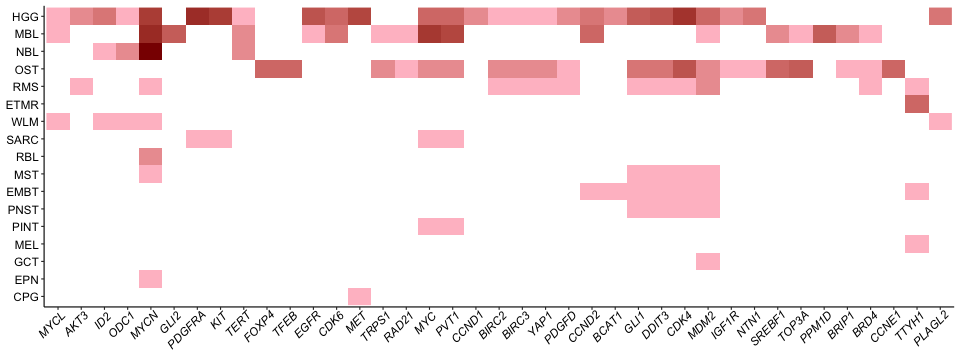

In [17]:
plot_gene_x_tumor_heatmap <- function(heatmap_data,subpanel=FALSE){
  if(subpanel){
    plot_tag <- element_text(size=8,face = "bold", colour = "black")
    tag="b"
  }else{
    plot_tag <- NULL
    tag=NULL
  }
  mapping <- aes(y = fct_inorder(cancer_type), x = fct_inorder(gene), fill = count) 
  hm <- ggplot(data=heatmap_data, mapping=mapping) +
    geom_raster() +
    #geom_tile(color = "grey50", fill = NA, alpha = 99,linewidth=0.1) +
    #scale_fill_distiller(name = "Patient tumor count", palette = "Blues", direction = 1, na.value = "white", trans = 'log10', ) +
    scale_fill_gradient(name = "Patient tumor count", na.value="white", trans = 'log10',  low="pink",high="darkred") +
    scale_y_discrete() + 
    labs(y="Tumor type", x="Oncogene", tag=tag) +
    theme_classic(base_size=7, base_family="Arial",) +
    theme(axis.text = element_text(size=7,colour="black"),
          axis.text.x = element_text(angle=45, vjust=1, hjust=0.9, face='italic'),
          #axis.text.y = element_text(),
          axis.title.y = element_blank(),
          axis.title.x = element_blank(),
          plot.tag = plot_tag,
          legend.position = "right", 
          legend.direction = "vertical",
          legend.key.size = unit(0.5,"cm"),
          #plot.margin = unit(c(0,0,0,0), "cm"),
          ) 
  return(hm)
}
options(repr.plot.width = 8, repr.plot.height = 3)
hmd <- get_heatmap_data(gene_x_tumor_amp_freq,ecDNA_amplicons,chromosomal_gene_order,sort_x=FALSE)
hm <- plot_gene_x_tumor_heatmap(hmd)
leg <- cowplot::get_legend(hm)
hm.clean <- hm + theme(legend.position="none")
hm.clean
#ggsave("out/heatmap_with_legend.svg", plot = hm, width = 12, height = 8)


Warning message in geom_col(stat = "identity", mapping):
“Ignoring unknown parameters: `stat`”


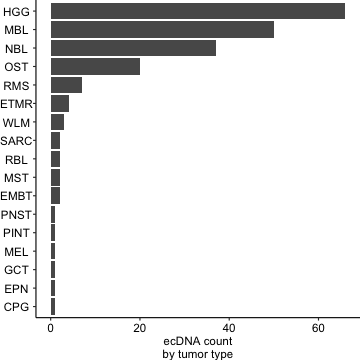

In [18]:
# Create y axis barplot
y_barplot <- function(data, color=FALSE, labels=FALSE, subpanel=FALSE) {
  # Color the bars or not
  if(color) {
    mapping <- aes(y = fct_inorder(cancer_type), x = count, fill = count)
  } else {
    mapping <- aes(y = fct_inorder(cancer_type), x = count)
  }
  
  # Label the x axis or not
  if(labels) {
    axis_text_y <- NULL#element_text(angle=45, vjust=0.5)
    axis_ticks_y <- NULL
  } else {
    axis_text_y <- element_blank()
    axis_ticks_y <- element_blank()
  }
  
  # Include subpanel labelling a, b, c etc.
  if(subpanel) {
    plot_tag <- element_text(size=8, face = "bold", colour = "black")
    tag = "a"
  } else {
    plot_tag <- NULL
    tag = NULL
  }
  
  # Create the bar plot
  bp.y <- ggplot(data = data, mapping = mapping) + 
    geom_col(stat = "identity", mapping) + 
    #scale_x_log10() +
    #annotation_logticks(sides='b') +
    theme_classic(base_size=7, base_family="Arial") + 
    theme(
      plot.margin = unit(c(0,0,0,0), "cm"),
      axis.text = element_text(colour="black", size=7),
      plot.tag = plot_tag,
      axis.text.y = axis_text_y,
      axis.title.y = element_blank(),
      axis.ticks.y = axis_ticks_y,
      legend.position = "none") + 
    scale_fill_distiller(name = "Value", palette = "Reds", direction = 1, trans = 'log10') + 
    labs(y = "Cancer Type", x = "ecDNA count\nby tumor type", tag=tag)
    #labs(y = "Cancer Type", x = "Patient tumors with frequently\necDNA-amplified oncogenes", tag=tag)
  
  return(bp.y)
}
ybpd <- get_y_barplot_data(ecDNA_amplicons,chromosomal_gene_order)
bp.y <- y_barplot(ybpd, color=FALSE, labels=TRUE)

# Save the plot as SVG
#ggsave("cancer_type_barplot.svg", plot = bp.x, width = 12, height = 8)  # Adjust width and height as needed
options(repr.plot.width = 3, repr.plot.height = 3)
bp.y


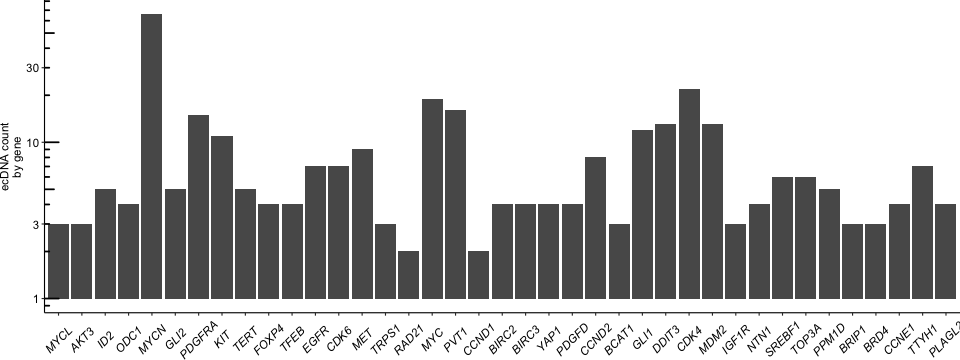

In [19]:
# Create x axis barplot
x_barplot <- function(data, color=FALSE, labels=FALSE, subpanel=FALSE){
  # Color the bars or not
  if(color){
    mapping <- aes(y = count, x = fct_rev(fct_inorder(gene)), fill = count)
  }else{
    mapping <- aes(y = count, x = fct_rev(fct_inorder(gene)))
  }
  # label the x axis or not
  if(labels){
    axis_text_x <- element_text(angle=45, vjust=0.5,face='italic')
    axis_ticks_x <- NULL
  }else{
    axis_text_x <- element_blank()
    axis_ticks_x <- element_blank()
  }
  # include subpanel labelling a, b, c etc.
  if(subpanel){
    plot_tag <- element_text(size=8,face = "bold", colour = "black")
    tag=""
  }else{
    plot_tag <- NULL
    tag=NULL
  }
  
  bp.x <- ggplot(data = data, mapping=mapping) + 
    geom_bar(mapping=mapping,stat='identity') + 
    scale_y_log10() +
    annotation_logticks(sides='l',outside=FALSE) +
    #coord_cartesian(clip = "off") +
    theme_classic(base_size=7, base_family="Arial") + 
    theme(
      plot.margin = unit(c(0,0,0,0), "cm"),
      axis.text = element_text(colour="black",size=7),
      plot.tag = plot_tag,
      axis.text.x = axis_text_x,
      axis.title.x = element_blank(),
      axis.ticks.x = axis_ticks_x,
      legend.position = "none") + 
    scale_fill_distiller(name = "Value", palette = "Reds", direction = 1, trans = 'log10' ) + 
    labs(y = "ecDNA count\nby gene", tag=tag)
    #labs(x = "Patient tumors with frequently\necDNA-amplified oncogenes", tag=tag)
  return(bp.x)
}
xbpd <- get_x_barplot_data(gene_x_tumor_amp_freq,chromosomal_gene_order,sort_x=FALSE)
bp.x <- x_barplot(xbpd,color=FALSE,labels=TRUE,subpanel=FALSE)
#ggsave("gene_barplot.svg", plot = bp.y, width = 8, height = 8)  # Adjust width and height as needed
options(repr.plot.width = 8, repr.plot.height = 3)
bp.x

In [20]:
assemble_plot <- function(bp.x,leg,hm.clean,bp.y){
  cowplot::plot_grid(
    bp.x, leg, hm.clean, bp.y,
    align = "hv",
    axis = "lrbt",
    nrow=2,
    ncol=2,
    rel_heights=c(1,2),
    rel_widths=c(4,1)
  )
}
#bp.y <- y_barplot(ybpd)
#bp.x <- x_barplot(xbpd)
#assemble_plot(bp.x,leg,hm.clean,bp.y)
#ggsave(filename="amplicon_plot_grey_bar.png",path="out",dpi=300,width=7,height=7,units="in",bg="white")
#ggsave(filename="amplicon_plot_grey_bar.svg",path="out",dpi=300,width=7,height=7,units="in")

Warning message in geom_col(stat = "identity", mapping):
“Ignoring unknown parameters: `stat`”


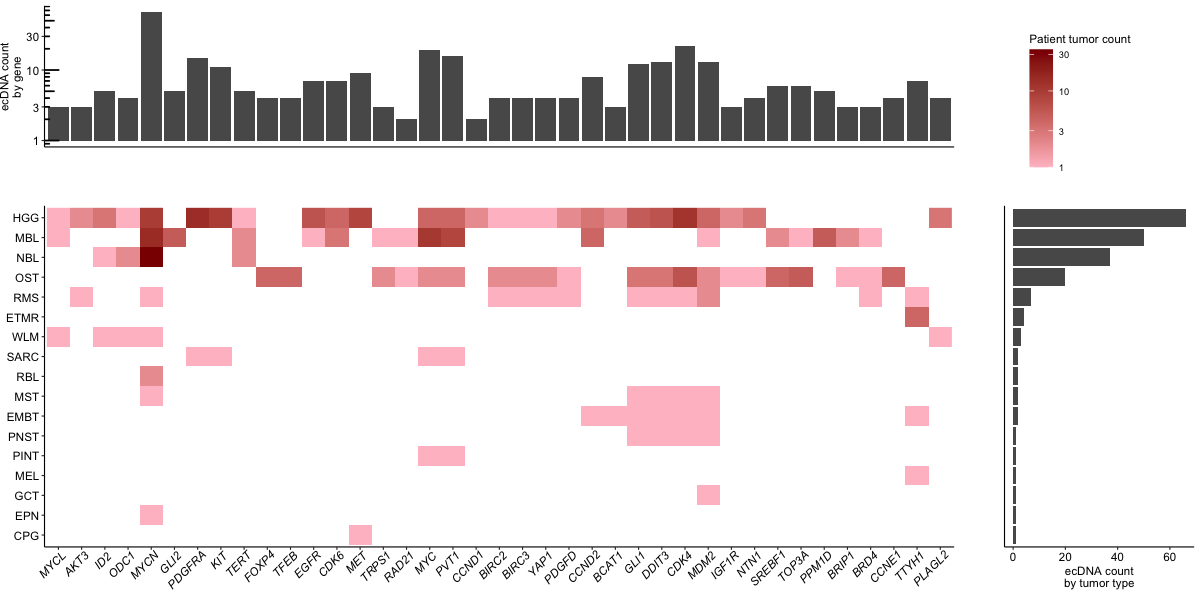

In [21]:
options(repr.plot.width = 10, repr.plot.height = 5)
bp.y <- y_barplot(ybpd, color=FALSE, labels=FALSE)
bp.x <- x_barplot(xbpd,color=FALSE,labels=FALSE,subpanel=FALSE)
assemble_plot(bp.x,leg,hm.clean,bp.y)
ggsave(filename="amplicon_plot_grey_bar5.png",path="out",dpi=300,width=180,height=90,units="mm",bg="white",create.dir=TRUE)
ggsave(filename="amplicon_plot_grey_bar5.svg",path="out",dpi=300,width=180,height=90,units="mm")